## Import the relevant packages

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

In [2]:
# Read the CSV into a dataframe

header_names = ['sample_code_number', 'clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape', 'marginal_adhesion', 'cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitosis', 'class']
data_df = pd.read_csv('breast-cancer-wisconsin - Copy.csv', header = None, names = header_names)


In [4]:
# Explore the dataframe

data_df.info()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
sample_code_number       699 non-null int64
clump_thickness          699 non-null int64
uniformity_cell_size     699 non-null int64
uniformity_cell_shape    699 non-null int64
marginal_adhesion        699 non-null int64
cell_size                699 non-null int64
bare_nuclei              699 non-null object
bland_chromatin          699 non-null int64
normal_nucleoli          699 non-null int64
mitosis                  699 non-null int64
class                    699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


sample_code_number  clump_thickness  uniformity_cell_size  \
0             1000025                5                     1   
1             1002945                5                     4   
2             1015425                3                     1   
3             1016277                6                     8   
4             1017023                4                     1   

   uniformity_cell_shape  marginal_adhesion  cell_size bare_nuclei  \
0                      1                  1          2           1   
1                      4                  5          7          10   
2                      1                  1          2           2   
3                      8                  1          3           4   
4                      1                  3          2           1   

   bland_chromatin  normal_nucleoli  mitosis  class  
0                3                1        1      2  
1                3                2        1      2  
2                3                1        1      2  
3                3                7        1      2  
4                3                1        1      2

We notice above that bare_nuclei is stored as an object instead of expected integer value. Lets determine what unexpected values are preventing integer values to be stored as object.

In [46]:
# Looking back at lecture, it is also possible to use regular expression to determine which entries are integers. Give this a try later.
indices_with_unexpected_values_in_bare_nuclei = ~data_df.bare_nuclei.isin(['1','2','3','4','5','6','7','8','9','10'])

rows_with_unexpected_values_in_bare_nuclei = data_df[~data_df.bare_nuclei.isin(['1','2','3','4','5','6','7','8','9','10'])]
print(rows_with_unexpected_values_in_bare_nuclei.bare_nuclei)
print("{} values are stored as '?'".format(len(rows_with_unexpected_values_in_bare_nuclei.bare_nuclei)) )

23     ?
40     ?
139    ?
145    ?
158    ?
164    ?
235    ?
249    ?
275    ?
292    ?
294    ?
297    ?
315    ?
321    ?
411    ?
617    ?
Name: bare_nuclei, dtype: object
16 values are stored as '?'


We observe that 16 records of bare_nuclei are stored as '?' but we do not expect these records to be missing. The missing values in the bare_nuclei_column are a small percentage of the benign and malignant tumors. Therefore, we can drop these records without significant impact to the solution of our classification problem.

In [45]:
print(rows_with_unexpected_values_in_bare_nuclei[['bare_nuclei', 'class']])
missing_by_tumor_class = rows_with_unexpected_values_in_bare_nuclei[['bare_nuclei', 'class']].groupby('class').count()
print(missing_by_tumor_class)

percentage_missing_in_benign = 100*missing_by_tumor_class.loc[2,'bare_nuclei']/population_by_tumor_class[2]
percentage_missing_in_malignant = 100*missing_by_tumor_class.loc[4,'bare_nuclei']/population_by_tumor_class[4]

print("Percentage of missing bare_nuclei in benign tumors: {0:2.2f}%".format( percentage_missing_in_benign))
print("Percentage of missing bare_nuclei in malignant tumors: {0:2.2f}%".format( percentage_missing_in_malignant))
# Class: (2 for benign, 4 for malignant)


    bare_nuclei  class
23            ?      4
40            ?      2
139           ?      2
145           ?      2
158           ?      2
164           ?      2
235           ?      2
249           ?      2
275           ?      2
292           ?      4
294           ?      2
297           ?      2
315           ?      2
321           ?      2
411           ?      2
617           ?      2
       bare_nuclei
class             
2               14
4                2
Percentage of missing bare_nuclei in benign tumors: 3.06%
Percentage of missing bare_nuclei in malignant tumors: 0.83%


Drop the missing data and change the type of bare_nuclei to int. Also, change the class of tumor to category type

In [51]:
data_df = data_df[~indices_with_unexpected_values_in_bare_nuclei]

data_df.bare_nuclei = data_df.bare_nuclei.astype('int64')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
sample_code_number       683 non-null int64
clump_thickness          683 non-null int64
uniformity_cell_size     683 non-null int64
uniformity_cell_shape    683 non-null int64
marginal_adhesion        683 non-null int64
cell_size                683 non-null int64
bare_nuclei              683 non-null int64
bland_chromatin          683 non-null int64
normal_nucleoli          683 non-null int64
mitosis                  683 non-null int64
class                    683 non-null int64
dtypes: int64(11)
memory usage: 64.0 KB


C:\Users\ggupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


458

Look for outliers

       sample_code_number  clump_thickness  uniformity_cell_size  \
count        6.830000e+02       683.000000            683.000000   
mean         1.076720e+06         4.442167              3.150805   
std          6.206440e+05         2.820761              3.065145   
min          6.337500e+04         1.000000              1.000000   
25%          8.776170e+05         2.000000              1.000000   
50%          1.171795e+06         4.000000              1.000000   
75%          1.238705e+06         6.000000              5.000000   
max          1.345435e+07        10.000000             10.000000   

       uniformity_cell_shape  marginal_adhesion   cell_size  bare_nuclei  \
count             683.000000         683.000000  683.000000   683.000000   
mean                3.215227           2.830161    3.234261     3.544656   
std                 2.988581           2.864562    2.223085     3.643857   
min                 1.000000           1.000000    1.000000     1.000000   
25%    

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Text xticklabel objects>)

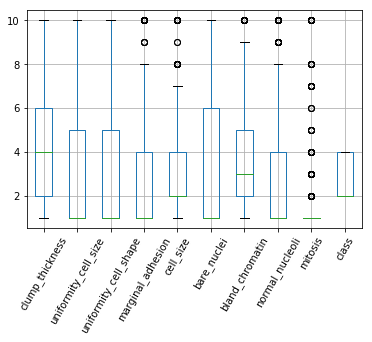

In [58]:
print(data_df.describe())
data_df.boxplot([ 'clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape', 'marginal_adhesion', 'cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitosis', 'class'])
plt.xticks(rotation = 60)

It can be seen that most of the attributes have reasonable spread. Interestingly, the median value is closer to the lower end of the range for all the attributes. 

Only mitosis attribute appears to have a large number of outliers. In fact, its inter quartile range (IQR) is limited to the value 1. After looking into the original data description, this attribute is determined by classifying how infrequently cell mitosis is occuring on a scale of 1 to 10. At this point there is no reason to think that these outliers are invalid.

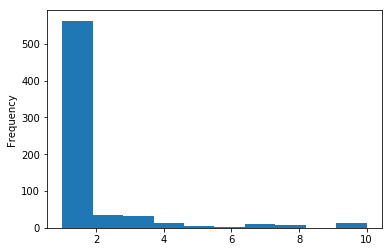

In [71]:
data_df.mitosis.plot(kind='hist')

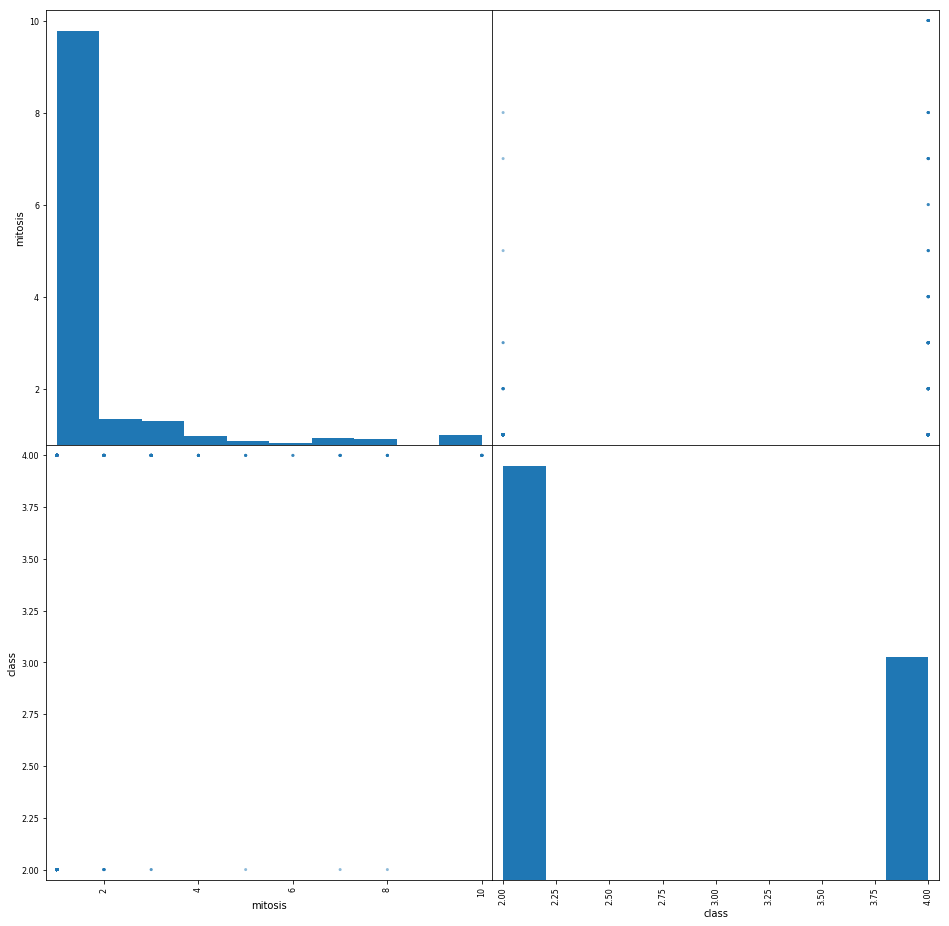

In [65]:
attributes = ['mitosis', 'class']
pd.plotting.scatter_matrix(data_df[attributes], figsize=(16,16))
#plt.xlabels(rotation = 60)
plt.show()

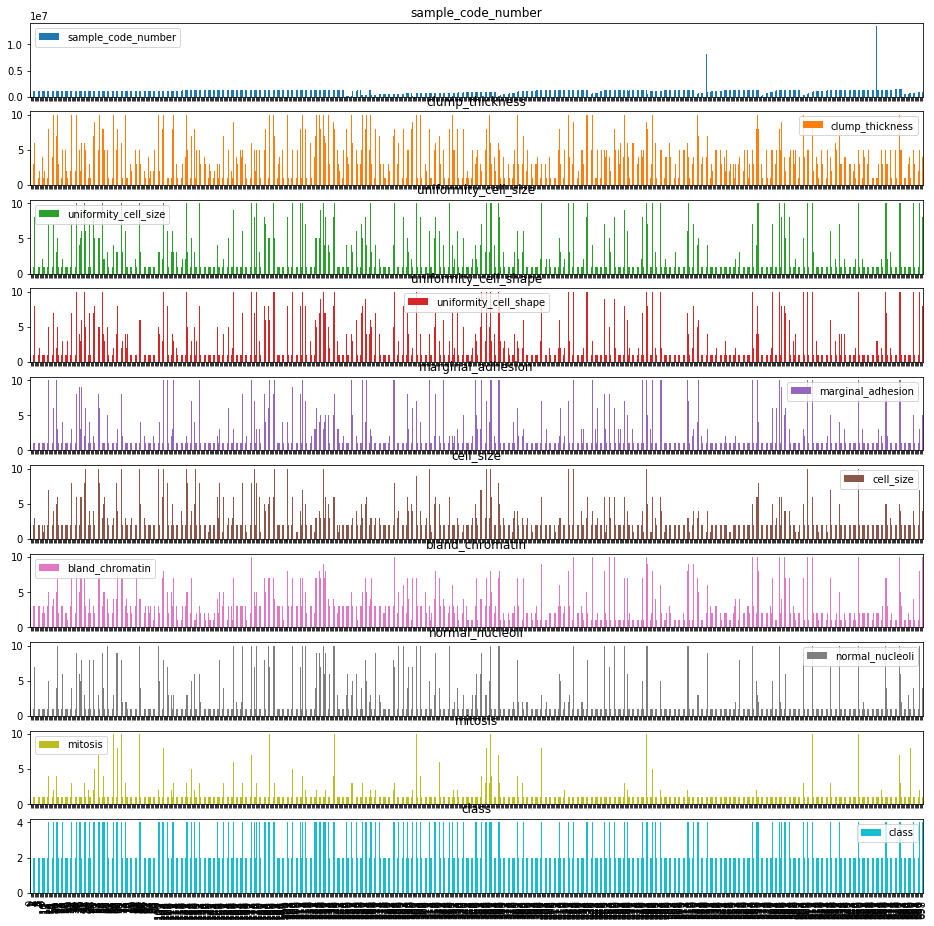

In [1]:

#print(data_df)

data_df.plot(subplots=True,figsize = (16,16), kind = 'bar')
"""
plt.subplot(1,2,1)
data_df['sample_code_number'].plot() 
plt.subplot(1,2,2)
data_df['clump_thickness'].plot() 

"""
plt.savefig('data_plot.jpg')
plt.show()


In [20]:


print("Number of missing values in the bare_nuclei column: ",sum(data_df.bare_nuclei == '?'))
print("proportion of missing values in bare_nuclei column: ", 100 * sum(data_df.bare_nuclei == '?')/len(data_df.bare_nuclei), "%")
data_df.bare_nuclei

# try NaN for bare_nuclei
data_df.bare_nuclei[data_df.bare_nuclei == '?'] = np.NaN
data_df.bare_nuclei = data_df.bare_nuclei.astype(float)

data_df.info()


C:\Users\ggupta\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1164: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

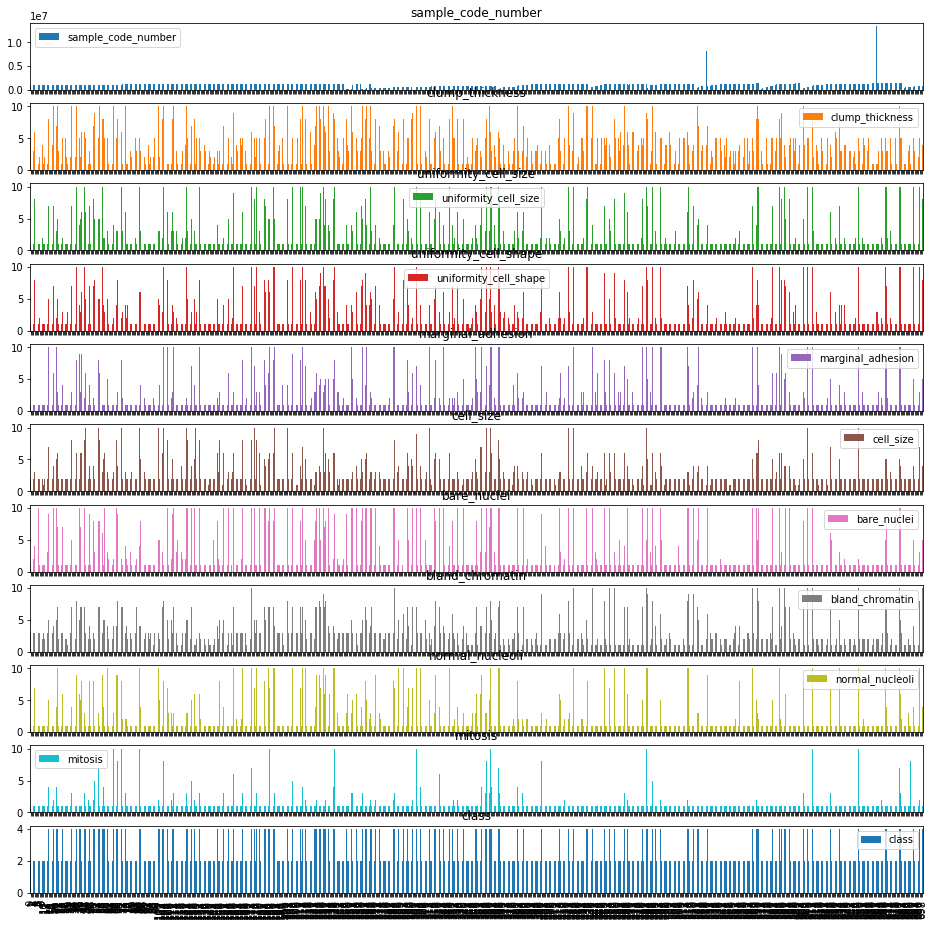

In [22]:
data_df.plot(subplots=True,figsize = (16,16), kind = 'bar')
plt.show()

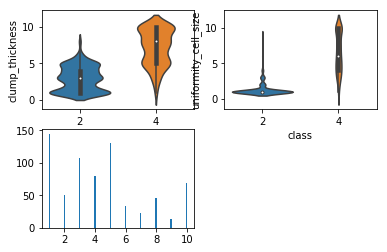

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


In [37]:
import seaborn as sns

plt.subplot(2,2,1)
sns.violinplot(x = 'class', y = 'clump_thickness', data = data_df)

plt.subplot(2,2,2)
sns.violinplot(x = 'class', y = 'uniformity_cell_size', data = data_df)


plt.subplot(2,2,3)
plt.hist(data_df['clump_thickness'], bins = 100)
plt.savefig('violin_plot.png')


In [45]:
data_df[data_df.cell_size.isnull()]

data_df[~data_df.bare_nuclei.isin([1,2,3,4,5,6,7,8,9,10])]

data_prep_df=data_df.replace('?', None)

print(data_prep_df.head(100))

    sample_code_number  clump_thickness  uniformity_cell_size  \
0              1000025                5                     1   
1              1002945                5                     4   
2              1015425                3                     1   
3              1016277                6                     8   
4              1017023                4                     1   
5              1017122                8                    10   
6              1018099                1                     1   
7              1018561                2                     1   
8              1033078                2                     1   
9              1033078                4                     2   
10             1035283                1                     1   
11             1036172                2                     1   
12             1041801                5                     3   
13             1043999                1                     1   
14             1044572   